### Importing libraries

In [166]:
import openpyxl as op
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
import numpy as np
import pandas as pd
from openpyxl import Workbook
import re
from IPython.display import set_matplotlib_formats
import collections
import plotly.graph_objects as go
import os
import glob
import plotly.express as px
import statistics
from openpyxl.utils.dataframe import dataframe_to_rows

### Statistics

In [190]:
pblocks_table = pd.read_csv('pblocks.tsv', sep='\t')


unique_isoform_pair = pd.unique(pblocks_table['other'])

len(unique_isoform_pair)

47048


### Plot 1

/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


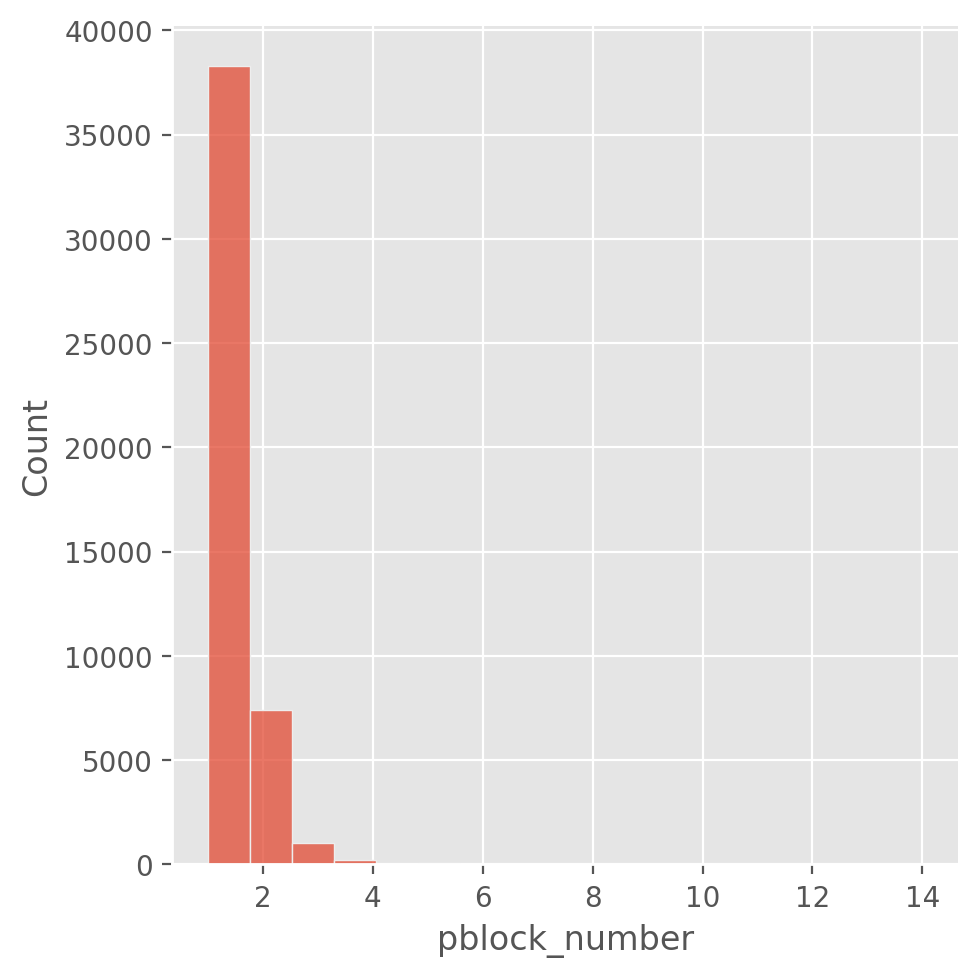

In [202]:
pblocks_table = pd.read_csv('pblocks.tsv', sep='\t')
pblock_per_isoform=pblocks_table.groupby(['anchor', 'other']).pblock_number.agg(('count'))
sns.displot(data=pblock_per_isoform, x= pblock_per_isoform)


### Plot 2: 

/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


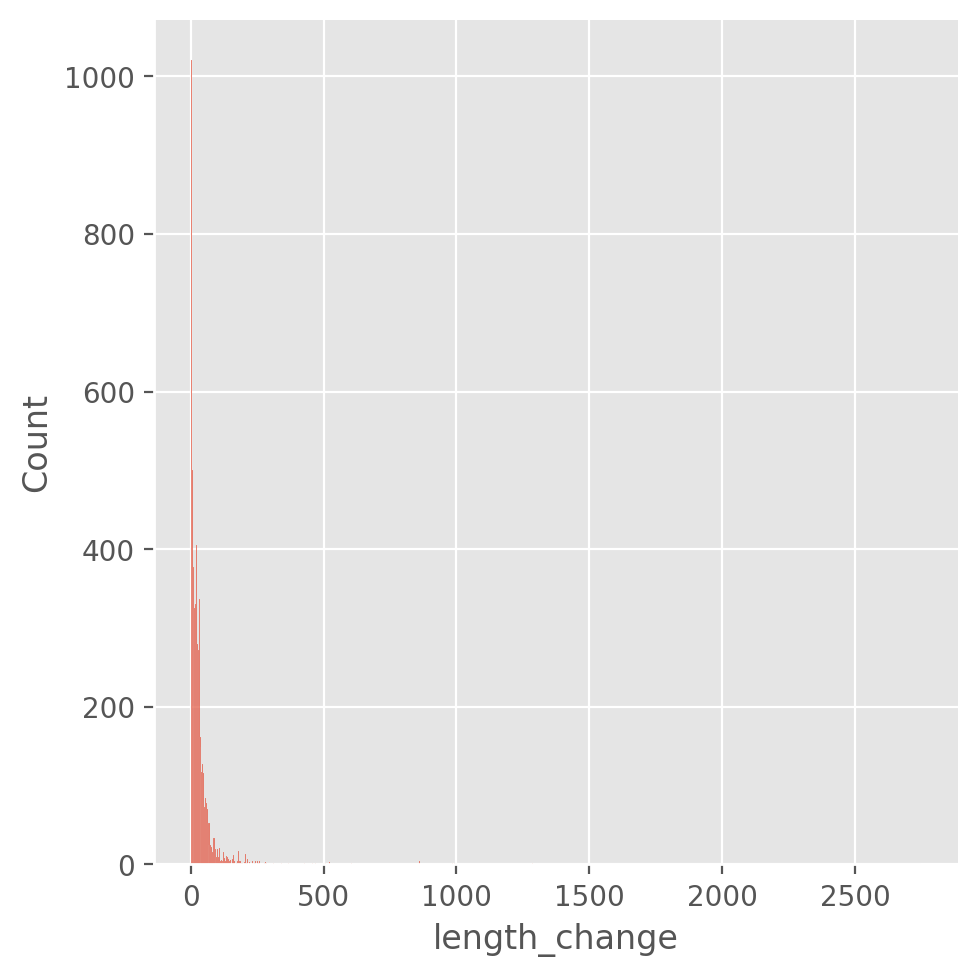

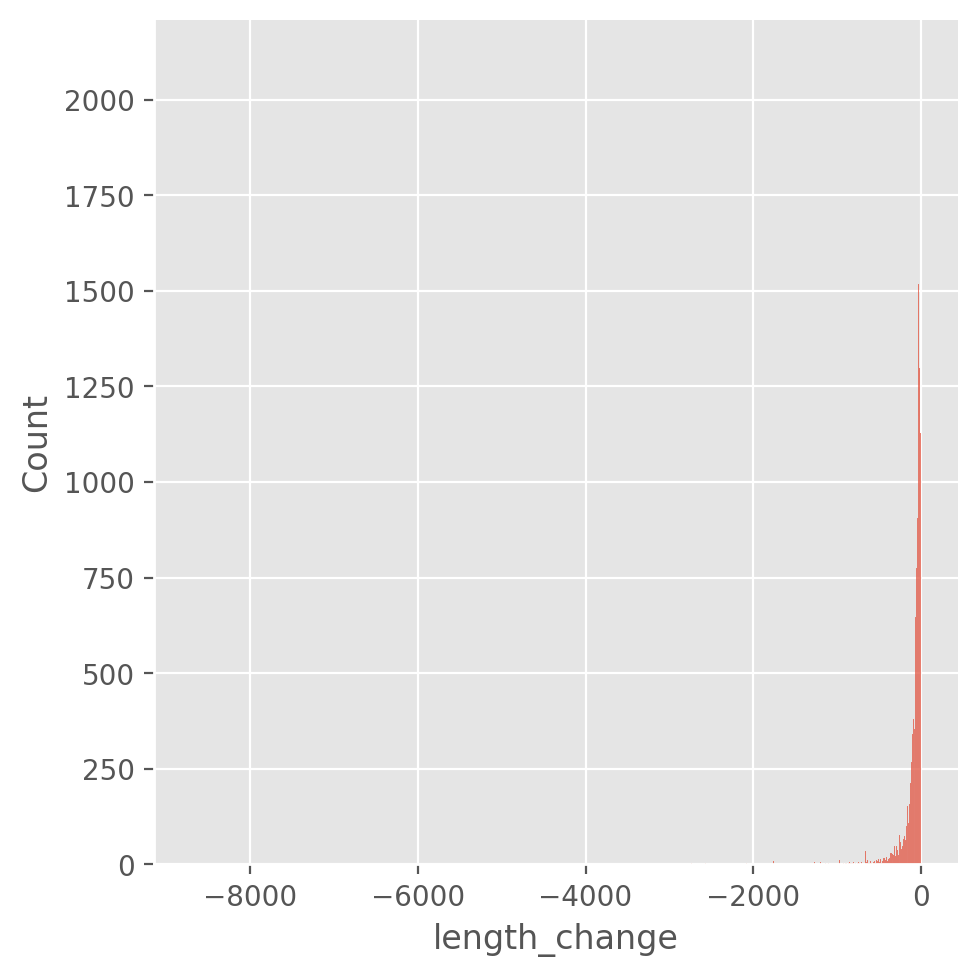

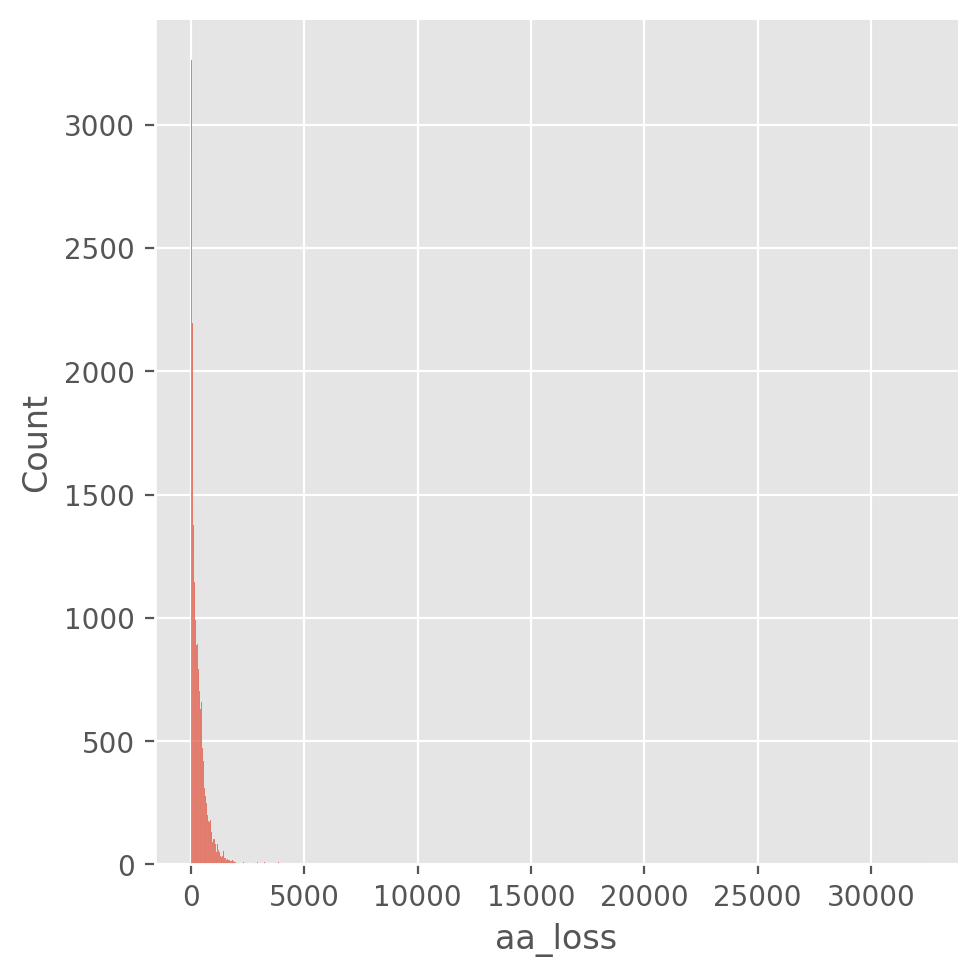

In [209]:
# Insertion
sns.displot(data=pblocks_table[pblocks_table['pblock_category']=='INSERTION'], x='length_change')

sns.displot(data=pblocks_table[pblocks_table['pblock_category']=='DELETION'], x='length_change')

# plotting aa loss
sns.displot(data=pblocks_table[pblocks_table['pblock_category']=='SUBSTITUTION'], x='aa_loss')

### Plot 3: 

<AxesSubplot:xlabel='aa_loss', ylabel='aa_gain'>

/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


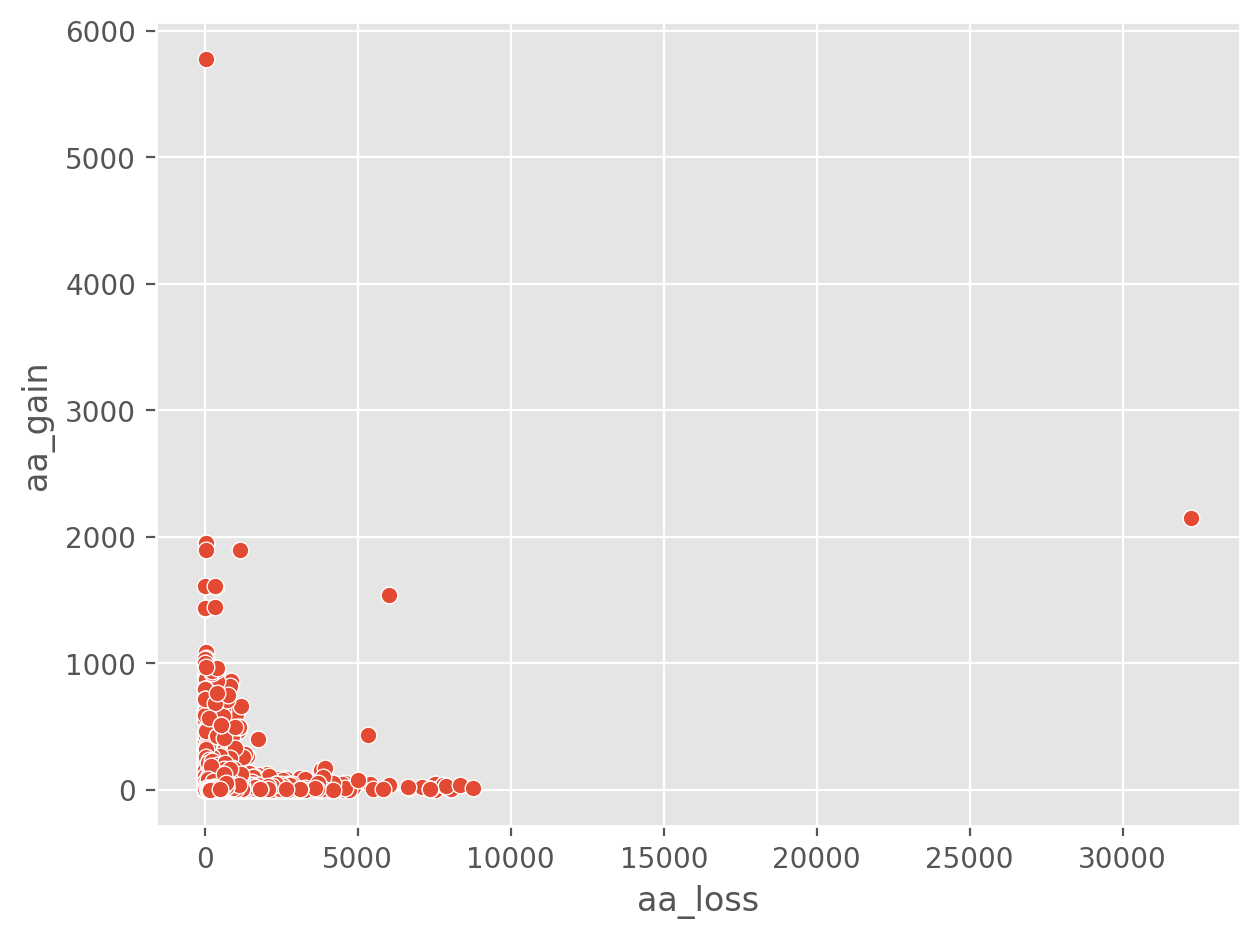

In [213]:
pblock_per_isoform=pblocks_table.groupby(['anchor', 'other'])
sns.scatterplot(data=pblocks_table[pblocks_table["pblock_category"]=="SUBSTITUTION"], x="aa_loss", y='aa_gain')

### Alt to pie chart

<AxesSubplot:xlabel='pblock_category', ylabel='count'>

/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


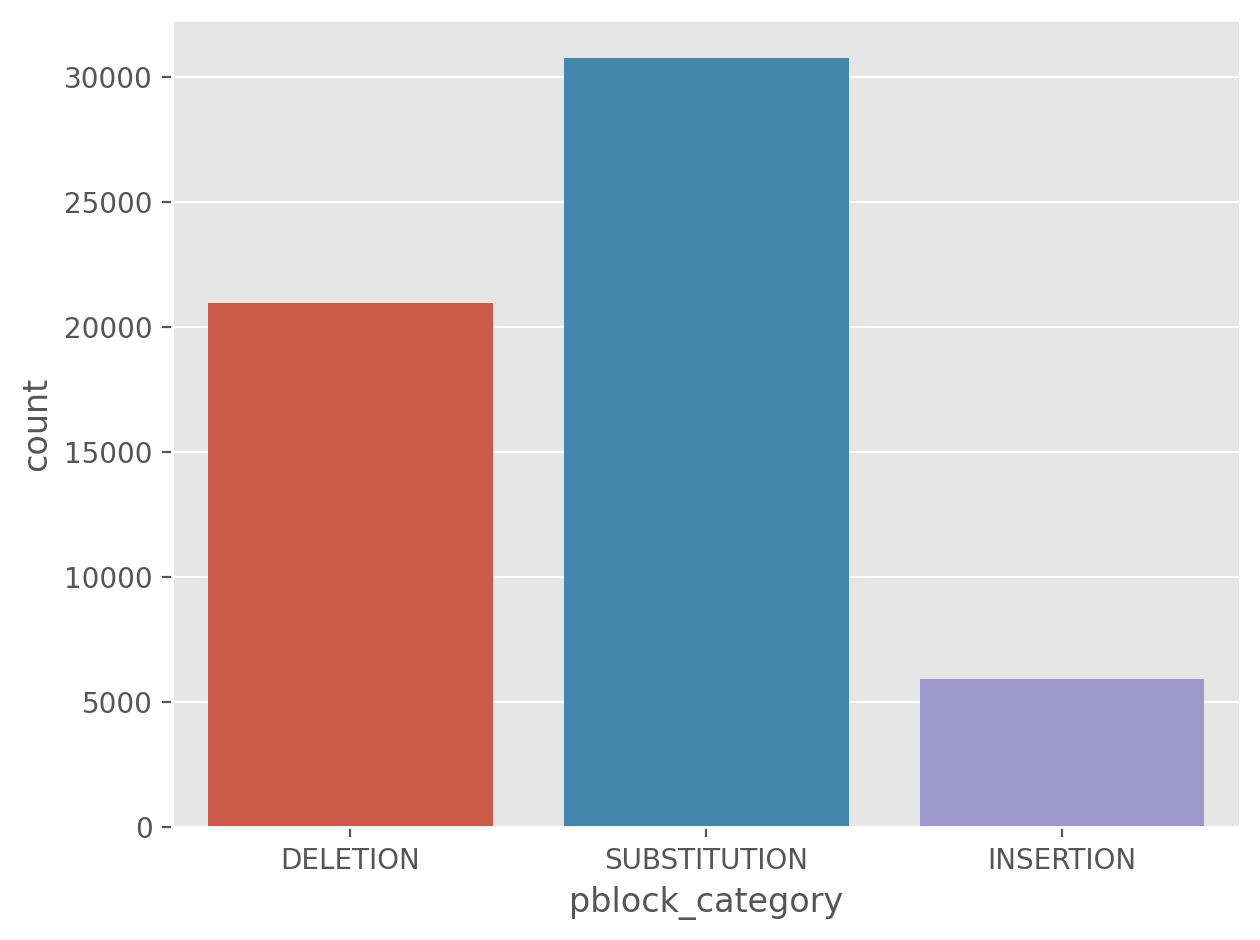

In [214]:
sns.countplot(x=pblocks_table['pblock_category'])

### Using a subset of pblocks table for summary plotting

In [175]:
# Loading pblock tsv file 
pblocks_table = pd.read_csv('pblocks.tsv', sep='\t')
pblocks_table_subset = pblocks_table[['anchor', 'other','pblock_category','pblock_anchor_start','pblock_anchor_stop','pblock_other_start','pblock_other_stop','anchor_seq','other_seq']]
pblocks_table_subset['gene'] = pblocks_table_subset['anchor']
pblocks_table_subset['gene'] = pblocks_table_subset.gene.str.extract('(.*?)-', expand=False)
pblocks_table_subset = pblocks_table_subset[['gene', 'anchor', 'other','pblock_category','pblock_anchor_start','pblock_anchor_stop','pblock_other_start','pblock_other_stop','anchor_seq','other_seq']]
# df['s-pblock_subcat']=0

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_50299/1501160947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pblocks_table_subset['gene'] = pblocks_table_subset['anchor']
/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_50299/1501160947.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pblocks_table_subset['gene'] = pblocks_table_subset.gene.str.extract('(.*?)-', expand=False)


In [176]:
pblocks_table_subset.head()
pblocks_table_subset.to_excel(r'pblock_intermediate.xlsx', index=False, header=True)

### Plot 1: Number of isoforms vs count of splice events affecting protein region plot
Plot how many protein regions (pblocks) are affected by splicing per isoform. 

In [177]:
wb = op.load_workbook(r'pblock_intermediate.xlsx')
sh = wb.active 

pb_stats = dict()
for x in range(1,51):
    pb_stats[x]=0

count = 1
for i in range(2, sh.max_row):
    # Alt isoform values for 2 cells to compare
    c1_iso, c2_iso = sh.cell(row=i, column=3), sh.cell(row=i+1, column=3)
    # Pblock values for 2 cells to compare
    c1_pb_cat, c2_pb_cat = sh.cell(row=i, column=4), sh.cell(row=i+1, column=4)
    c1_pb_anch_start, c2_pb_anch_start = sh.cell(row=i, column=5), sh.cell(row=i+1, column=5)
    c1_pb_anch_stop, c2_pb_anch_stop = sh.cell(row=i, column=6), sh.cell(row=i+1, column=6)
    c1_pb_othr_start, c2_pb_othr_start = sh.cell(row=i, column=7), sh.cell(row=i+1, column=7)
    c1_pb_othr_stop, c2_pb_othr_stop = sh.cell(row=i, column=8), sh.cell(row=i+1, column=8)
    
    # Both cells have same isoforms
    if c1_iso.value == c2_iso.value:
        # Have different pblocks
        if (c1_pb_cat.value!=c2_pb_cat.value) and (c1_pb_anch_start!=c2_pb_anch_start) and (c1_pb_anch_stop!=c2_pb_anch_stop) and (c1_pb_othr_start!=c2_pb_othr_start) and (c1_pb_othr_stop!=c2_pb_othr_stop):
            count+=1
            
    #When isoforms are different
    else:
        # # To get isoforms with extreme values


        # Updating count
        pb_stats[count]+=1
        count=1

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_50299/1914929928.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


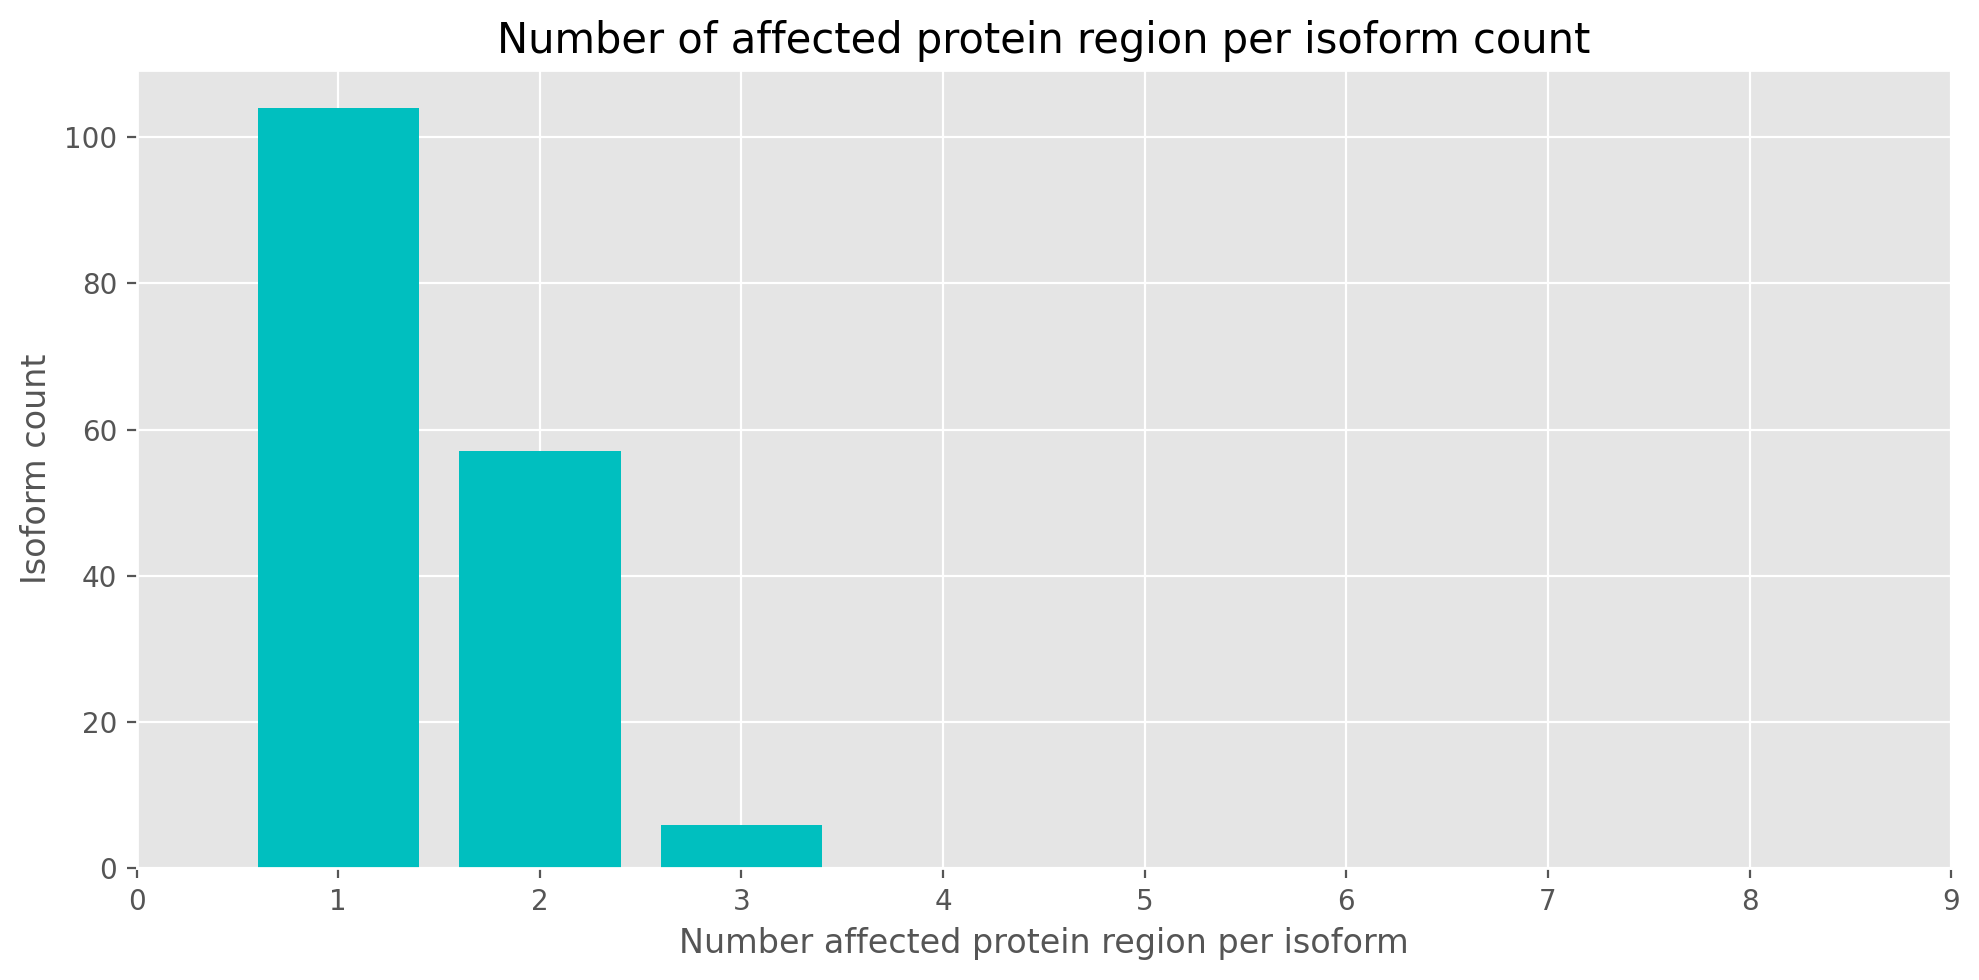

In [178]:
set_matplotlib_formats('retina', quality=1200)

plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')

plt.figure(figsize=(10,5))
#plt.yscale('log')
plt.xlim(0, 9)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.xlabel('Number affected protein region per isoform')
plt.ylabel('Isoform count')
plt.title('Number of affected protein region per isoform count', fontsize=15)
plt.bar(pb_stats.keys(), pb_stats.values(), width=0.8, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()
#Saving figure
#fig.savefig('../../C_toy_plots/isoform_pblock_count_histogram.png', dpi=1200)

### Plot 2: Size of affected protein regions vs number of isoform aggregate plot
To see what's the size of the pblocks being affected per isoform


In [179]:
wb = op.load_workbook(r'pblock_intermediate.xlsx')
sh = wb.active 
pb_stats_size = []

def getsize(c1_pb_anch_start_val, c1_pb_anch_stop, c1_pb_othr_start, c1_pb_othr_stop, sh, c1_iso_val):

    size = c1_pb_anch_stop-c1_pb_anch_start_val
    if  size == 0:
        size = c1_pb_othr_stop-c1_pb_othr_start
    pb_stats_size.append(size)
    return 0


for i in range(2, sh.max_row):
    c1_ref, c2_ref = sh.cell(row=i, column=2), sh.cell(row=i+1, column=2)
    c1_iso, c2_iso = sh.cell(row=i, column=3), sh.cell(row=i+1, column=3)
    c1_pb_cat, c2_pb_cat = sh.cell(row=i, column=4), sh.cell(row=i+1, column=4)
    c1_pb_anch_start, c2_pb_anch_start = sh.cell(row=i, column=5), sh.cell(row=i+1, column=5)
    c1_pb_anch_stop, c2_pb_anch_stop = sh.cell(row=i, column=6), sh.cell(row=i+1, column=6)
    c1_pb_othr_start, c2_pb_othr_start = sh.cell(row=i, column=7), sh.cell(row=i+1, column=7)
    c1_pb_othr_stop, c2_pb_othr_stop = sh.cell(row=i, column=8), sh.cell(row=i+1, column=8)

    # When iso are same
    if c1_iso.value == c2_iso.value:
        if (c1_pb_cat.value!=c2_pb_cat.value) and (c1_pb_anch_start!=c2_pb_anch_start) and (c1_pb__anch_stop!=c2_pb_anch_stop) and (c1_pb_othr_start!=c2_pb_othr_start) and (c1_pb_othr_stop!=c2_pb_othr_stop):
            getsize(c1_pb_anch_start.value, c1_pb_anch_stop.value, c1_pb_othr_start.value, c1_pb_othr_stop.value, sh, c1_iso.value)
    #When iso are different
    else: 
        getsize(c1_pb_anch_start.value, c1_pb_anch_stop.value, c1_pb_othr_start.value, c1_pb_othr_stop.value, sh, c1_iso.value)

counter = collections.Counter(pb_stats_size)
#counter=sorted(counter.items())

#print(counter)
x1 = list(counter.keys())
y1 = list(counter.values())

average_size = sum(pb_stats_size)/len(pb_stats_size)
print(average_size)
print(statistics.median(pb_stats_size))


TypeError: unsupported operand type(s) for -: 'Cell' and 'int'

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_50299/1454769856.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)


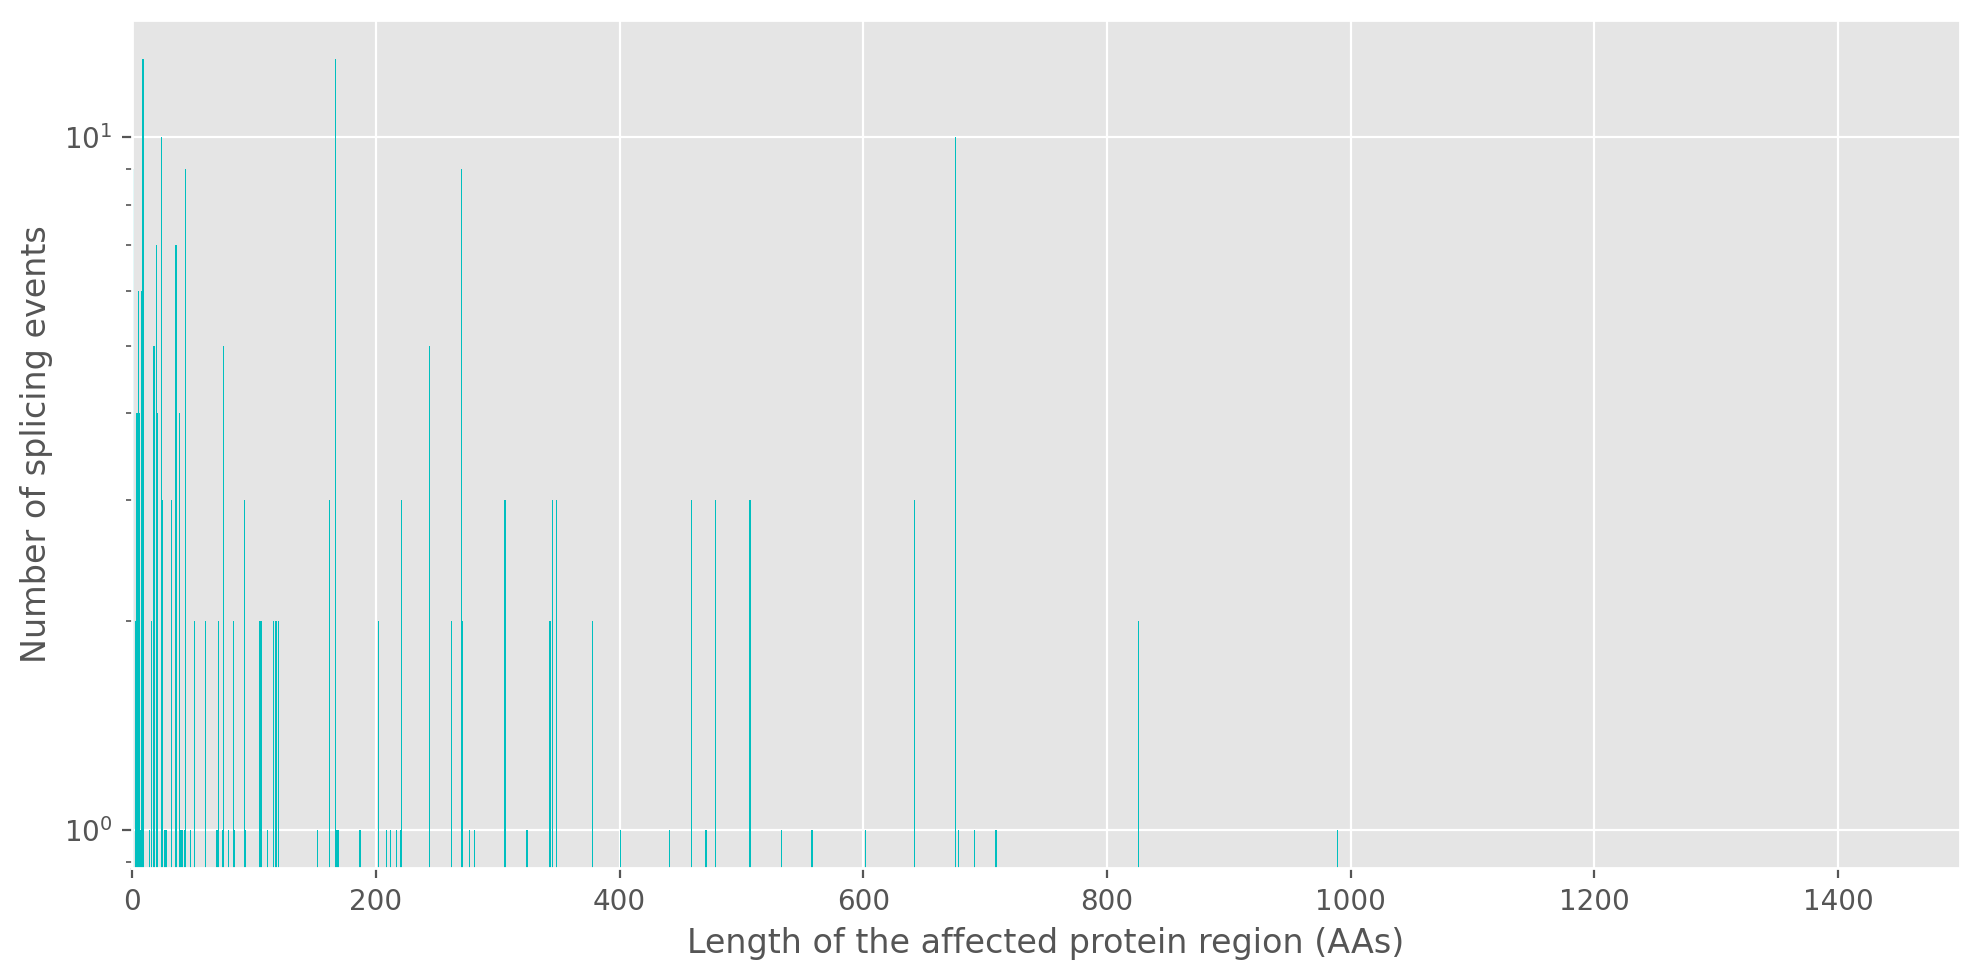

In [136]:
set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
#plt.style.use('ggplot')


plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
#plt.title('Number of affected protein region per isoform count', fontsize=15)
plt.bar(x1, y1, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
#fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram.png', dpi=1200)

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_50299/1663501853.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


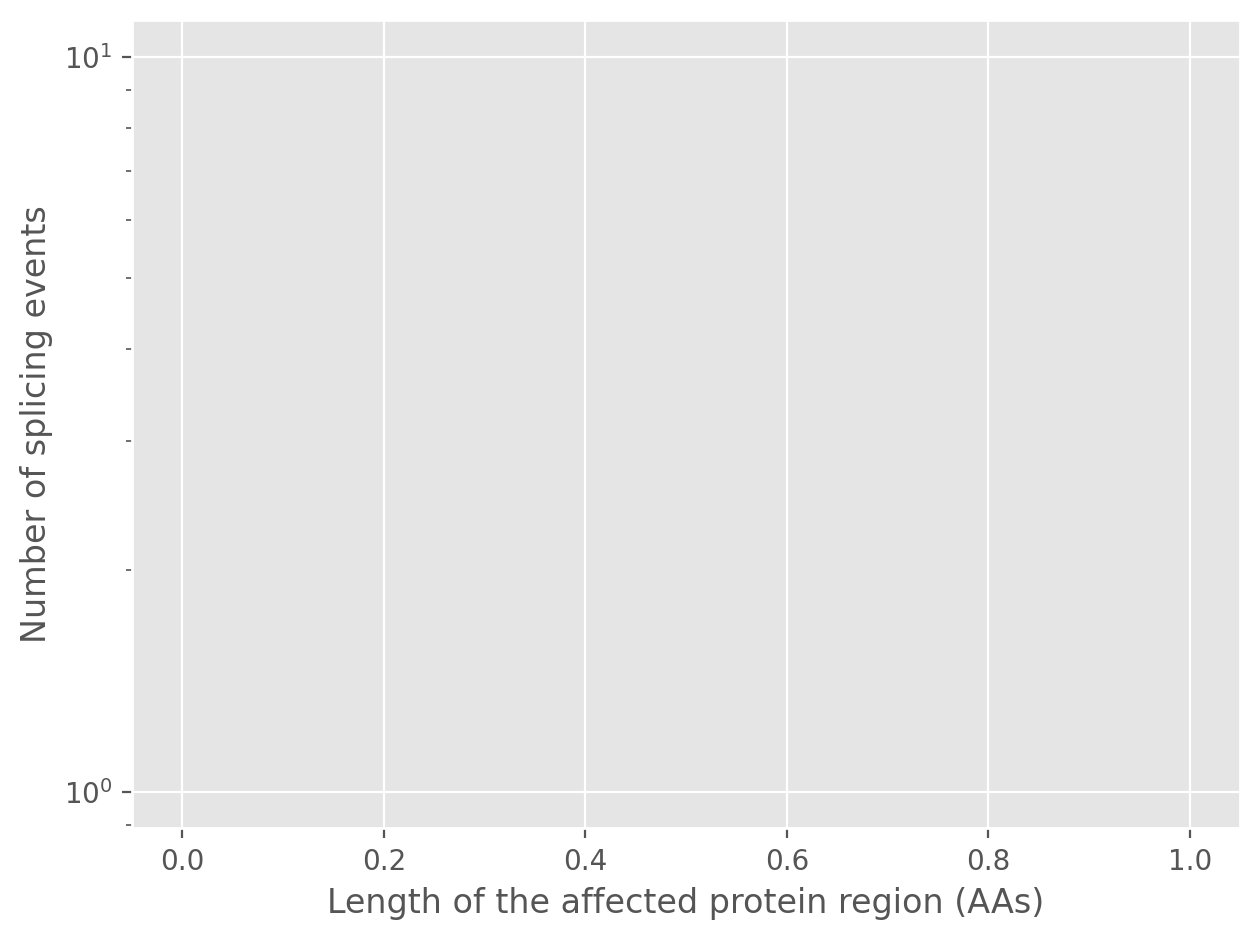

In [180]:
plt.hist(pb_stats_size, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 3: Size of affected protein regions vs number of isoform aggregate plot for Insertion splicing event
To see what's the size of the pblocks being affected per isoform


In [147]:
wb = op.load_workbook(r'pblock_intermediate.xlsx')
sh = wb.active 
pb_stats_size_I=[]


def getsize(c1_pb_cat, c1_pb_anch_start, c1_pb__anch_stop, c1_pb_othr_start, c1_pb_othr_stop, sh, c1_iso_val):

    size = c1_pb_anch_stop-c1_pb_anch_start
    if  size == 0:
        size = c1_pb_othr_stop-c1_pb_othr_start
    pb_stats_size.append(size)
    if c1_pb_cat=="INSERTION":
        pb_stats_size_I.append(size)
    return 0


for i in range(2, sh.max_row):
    c1_ref, c2_ref = sh.cell(row=i, column=2), sh.cell(row=i+1, column=2)
    c1_iso, c2_iso = sh.cell(row=i, column=3), sh.cell(row=i+1, column=3)
    c1_pb_cat, c2_pb_cat = sh.cell(row=i, column=4), sh.cell(row=i+1, column=4)
    c1_pb_anch_start, c2_pb_anch_start = sh.cell(row=i, column=5), sh.cell(row=i+1, column=5)
    c1_pb_anch_stop, c2_pb_anch_stop = sh.cell(row=i, column=6), sh.cell(row=i+1, column=6)
    c1_pb_othr_start, c2_pb_othr_start = sh.cell(row=i, column=7), sh.cell(row=i+1, column=7)
    c1_pb_othr_stop, c2_pb_othr_stop = sh.cell(row=i, column=8), sh.cell(row=i+1, column=8)

    # When iso are same
    if c1_iso.value == c2_iso.value:
        if (c1_pb_cat.value!=c2_pb_cat.value) and (c1_pb_anch_start!=c2_pb_anch_start) and (c1_pb__anch_stop!=c2_pb_anch_stop) and (c1_pb_othr_start!=c2_pb_othr_start) and (c1_pb_othr_stop!=c2_pb_othr_stop):
            #pblock is different for the iso
            getsize(c1_pb_cat.value, c1_pb_anch_start.value, c1_pb_anch_stop.value, c1_pb_othr_start.value, c1_pb_othr_stop.value, sh, c1_iso.value)

    #When iso are different
    else: 
        getsize(c1_pb_cat.value, c1_pb_anch_start.value, c1_pb_anch_stop.value, c1_pb_othr_start.value, c1_pb_othr_stop.value, sh, c1_iso.value)
            
counter = collections.Counter(pb_stats_size_I)
#print(counter)
xi = list(counter.keys())
yi = list(counter.values())

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_50299/1319109889.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


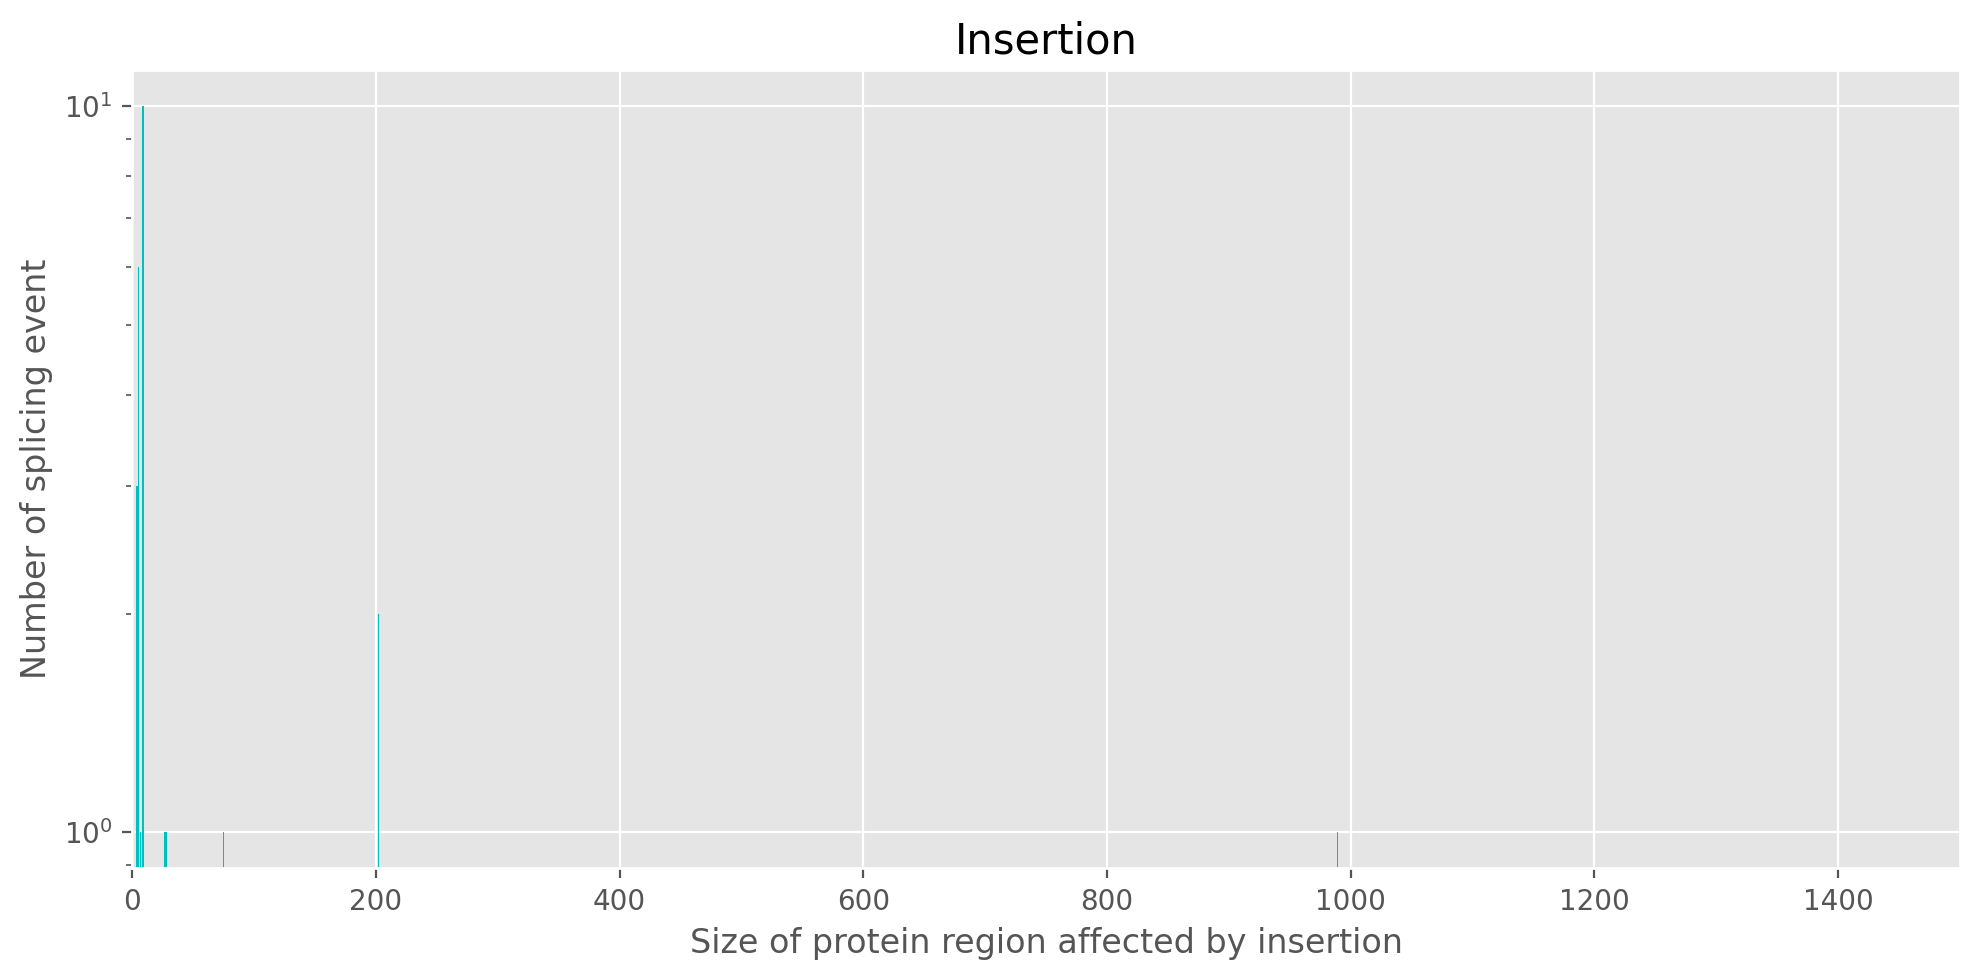

In [148]:
set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')

plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.title("Insertion", fontsize=15)
plt.xlabel('Size of protein region affected by insertion')
plt.ylabel('Number of splicing event')

plt.bar(xi, yi, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
#fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram_I.png', dpi=1200)


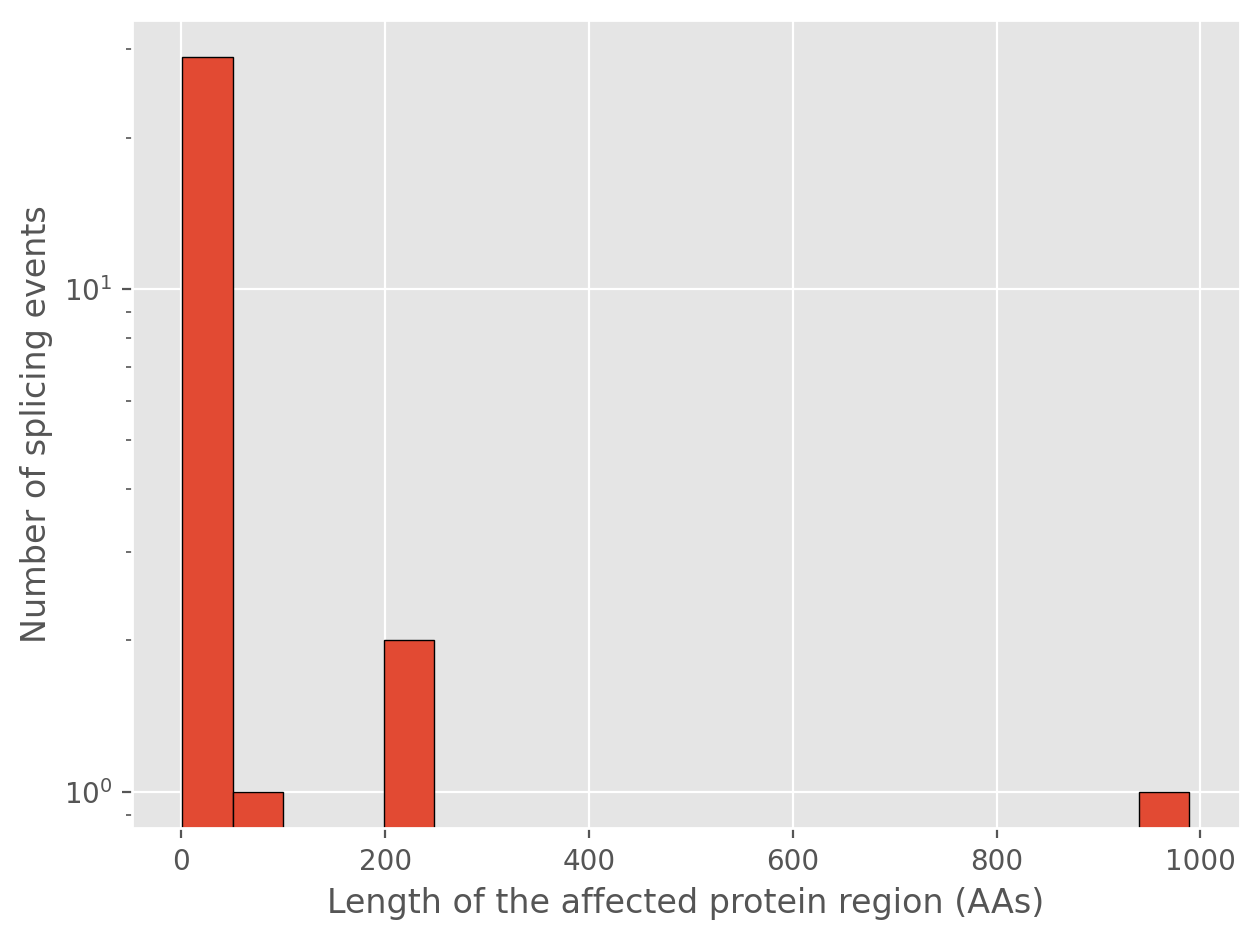

In [149]:
plt.hist(pb_stats_size_I, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 4: Size of affected protein regions vs number of isoform aggregate plot for deletion splice event
To see what's the size of the pblocks being affected per isoform


In [152]:
wb = op.load_workbook(r'pblock_intermediate.xlsx')
sh = wb.active 
pb_stats_size_D=[]

def getsize(c1_pb_cat, c1_pb_anch_start, c1_pb__anch_stop, c1_pb_othr_start, c1_pb_othr_stop, sh, c1_iso_val):

    size = c1_pb_anch_stop-c1_pb_anch_start
    if  size == 0:
        size = c1_pb_othr_stop-c1_pb_othr_start
    pb_stats_size.append(size)
    if c1_pb_cat=="DELETION":
        pb_stats_size_D.append(size)
    return 0


for i in range(2, sh.max_row):
    c1_ref, c2_ref = sh.cell(row=i, column=2), sh.cell(row=i+1, column=2)
    c1_iso, c2_iso = sh.cell(row=i, column=3), sh.cell(row=i+1, column=3)
    c1_pb_cat, c2_pb_cat = sh.cell(row=i, column=4), sh.cell(row=i+1, column=4)
    c1_pb_anch_start, c2_pb_anch_start = sh.cell(row=i, column=5), sh.cell(row=i+1, column=5)
    c1_pb_anch_stop, c2_pb_anch_stop = sh.cell(row=i, column=6), sh.cell(row=i+1, column=6)
    c1_pb_othr_start, c2_pb_othr_start = sh.cell(row=i, column=7), sh.cell(row=i+1, column=7)
    c1_pb_othr_stop, c2_pb_othr_stop = sh.cell(row=i, column=8), sh.cell(row=i+1, column=8)

    # When iso are same
    if c1_iso.value == c2_iso.value:
        if (c1_pb_cat.value!=c2_pb_cat.value) and (c1_pb_anch_start!=c2_pb_anch_start) and (c1_pb__anch_stop!=c2_pb_anch_stop) and (c1_pb_othr_start!=c2_pb_othr_start) and (c1_pb_othr_stop!=c2_pb_othr_stop):
            #pblock is different for the iso
            getsize(c1_pb_cat.value, c1_pb_anch_start.value, c1_pb_anch_stop.value, c1_pb_othr_start.value, c1_pb_othr_stop.value, sh, c1_iso.value)

    #When iso are different
    else: 
        getsize(c1_pb_cat.value, c1_pb_anch_start.value, c1_pb_anch_stop.value, c1_pb_othr_start.value, c1_pb_othr_stop.value, sh, c1_iso.value)
            
counter = collections.Counter(pb_stats_size_D)
#print(counter)
xd = list(counter.keys())
yd = list(counter.values())

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_50299/3670703786.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


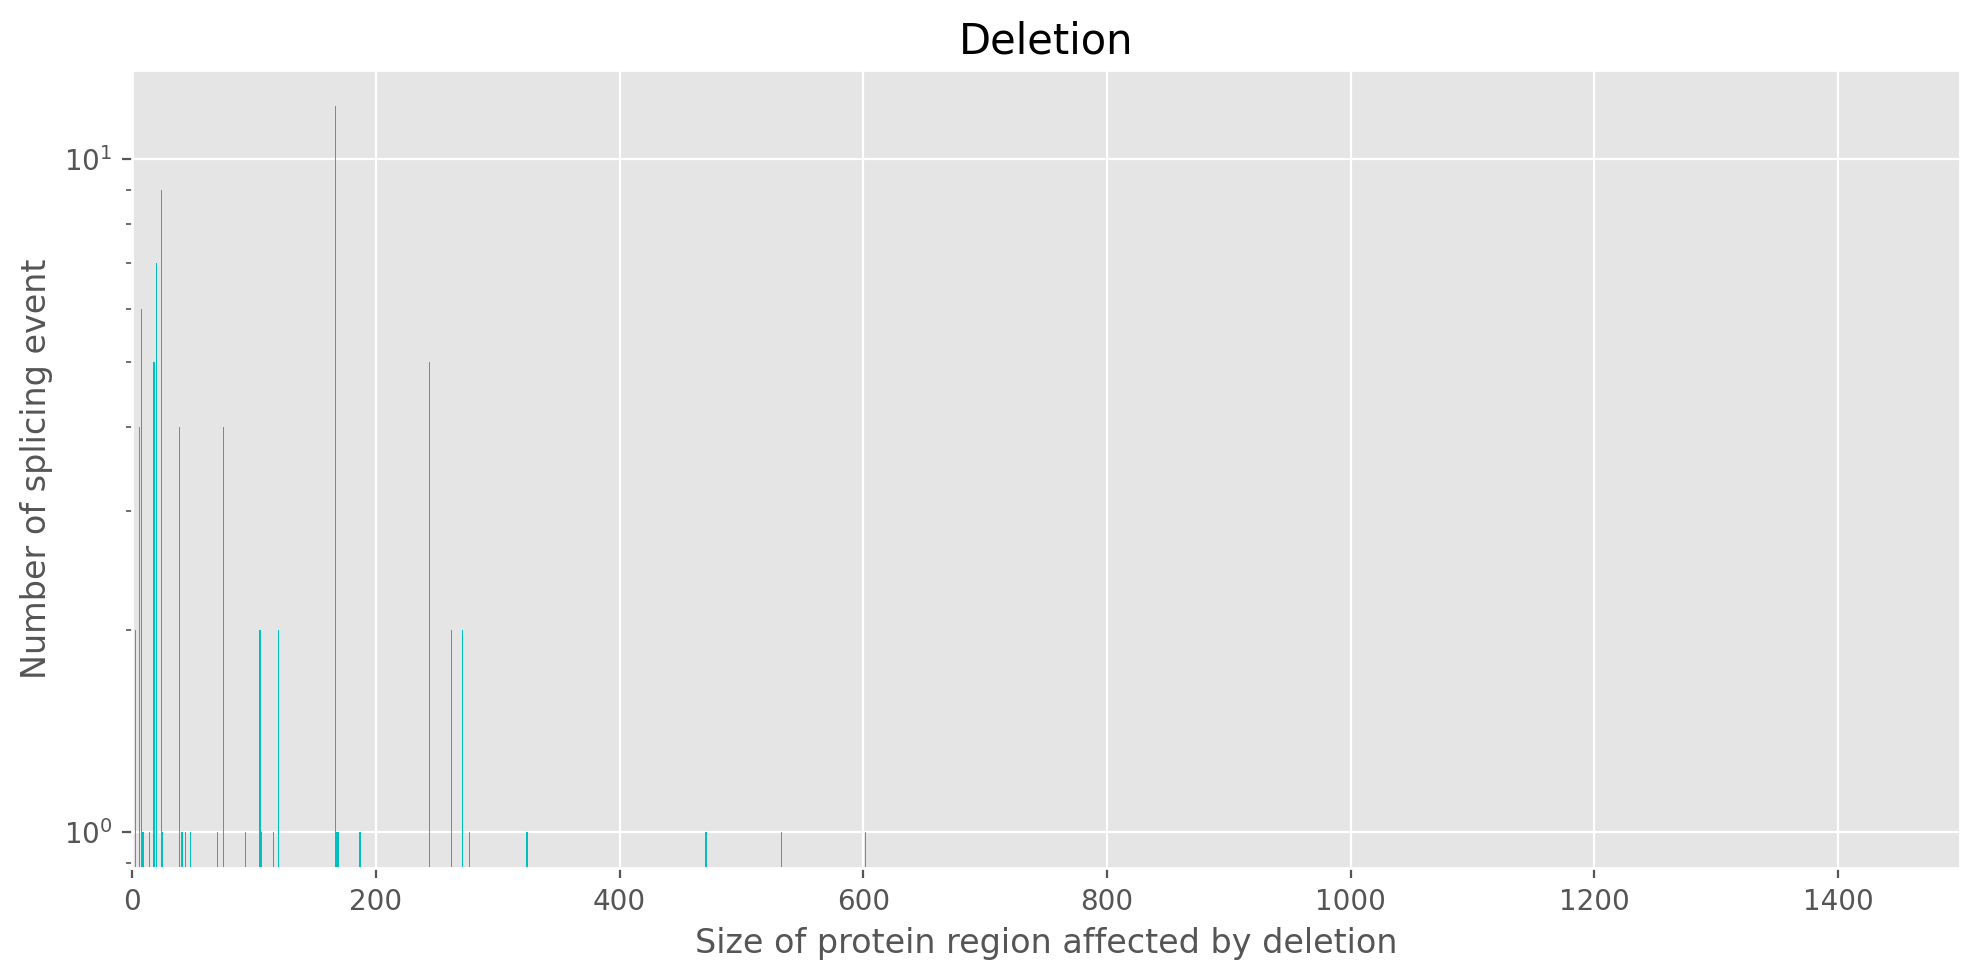

In [153]:

set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')

plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.title("Deletion", fontsize=15)
plt.xlabel('Size of protein region affected by deletion')
plt.ylabel('Number of splicing event')

plt.bar(xd, yd, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
#fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram_D.png', dpi=1200)


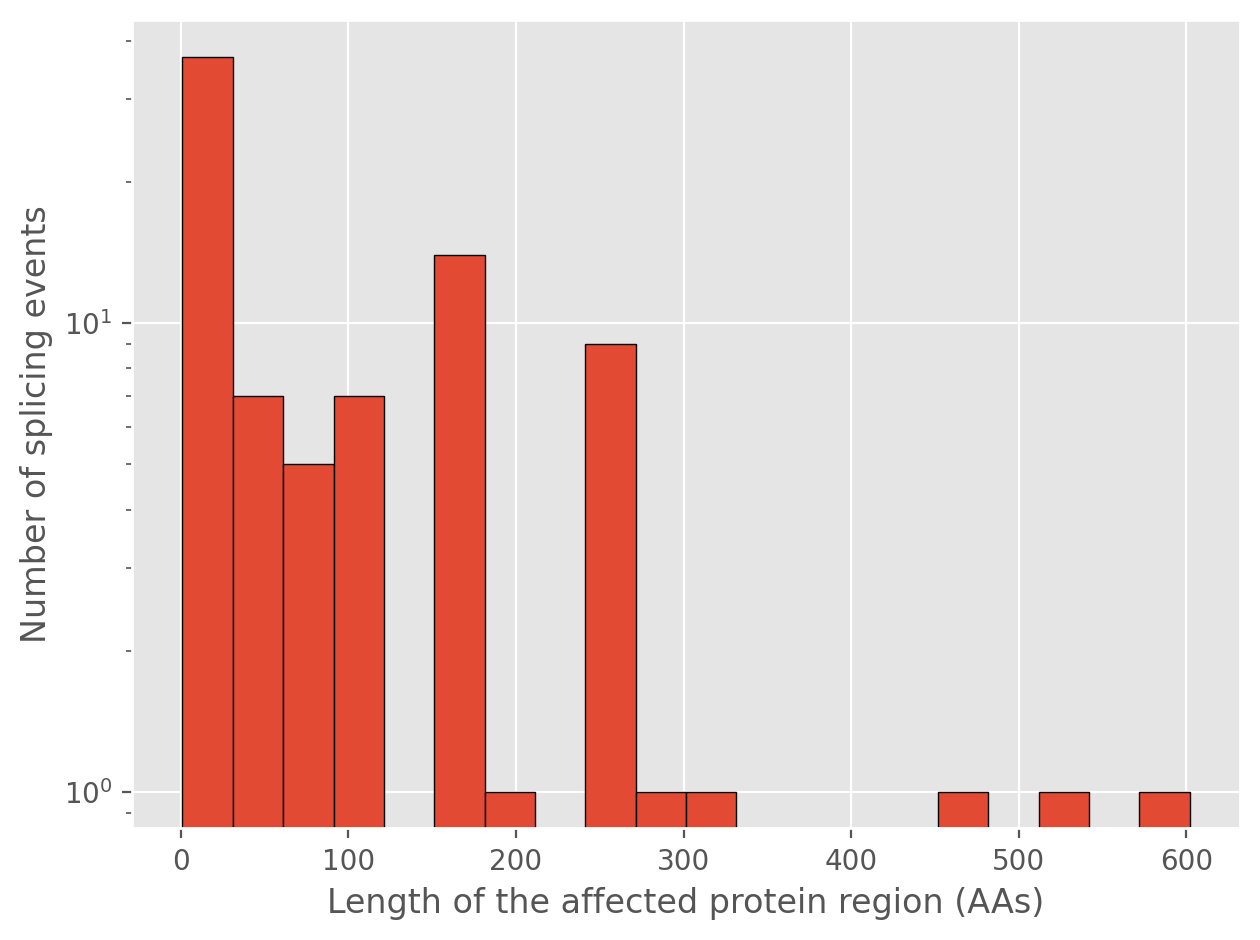

In [154]:
plt.hist(pb_stats_size_D, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 5: Size of affected protein regions vs number of isoform aggregate plot for substitution splice event
To see what's the size of the pblocks being affected per isoform


In [155]:
wb = op.load_workbook(r'pblock_intermediate.xlsx')
sh = wb.active 
pb_stats_size_S=[]

def getsize(c1_pb_cat, c1_pb_anch_start, c1_pb__anch_stop, c1_pb_othr_start, c1_pb_othr_stop, sh, c1_iso_val):

    size = c1_pb_anch_stop-c1_pb_anch_start
    if  size == 0:
        size = c1_pb_othr_stop-c1_pb_othr_start
    pb_stats_size.append(size)
    if c1_pb_cat=="SUBSTITUTION":
        pb_stats_size_S.append(size)
    return 0


for i in range(2, sh.max_row):
    c1_ref, c2_ref = sh.cell(row=i, column=2), sh.cell(row=i+1, column=2)
    c1_iso, c2_iso = sh.cell(row=i, column=3), sh.cell(row=i+1, column=3)
    c1_pb_cat, c2_pb_cat = sh.cell(row=i, column=4), sh.cell(row=i+1, column=4)
    c1_pb_anch_start, c2_pb_anch_start = sh.cell(row=i, column=5), sh.cell(row=i+1, column=5)
    c1_pb_anch_stop, c2_pb_anch_stop = sh.cell(row=i, column=6), sh.cell(row=i+1, column=6)
    c1_pb_othr_start, c2_pb_othr_start = sh.cell(row=i, column=7), sh.cell(row=i+1, column=7)
    c1_pb_othr_stop, c2_pb_othr_stop = sh.cell(row=i, column=8), sh.cell(row=i+1, column=8)

    # When iso are same
    if c1_iso.value == c2_iso.value:
        if (c1_pb_cat.value!=c2_pb_cat.value) and (c1_pb_anch_start!=c2_pb_anch_start) and (c1_pb__anch_stop!=c2_pb_anch_stop) and (c1_pb_othr_start!=c2_pb_othr_start) and (c1_pb_othr_stop!=c2_pb_othr_stop):
            #pblock is different for the iso
            getsize(c1_pb_cat.value, c1_pb_anch_start.value, c1_pb_anch_stop.value, c1_pb_othr_start.value, c1_pb_othr_stop.value, sh, c1_iso.value)

    #When iso are different
    else: 
        getsize(c1_pb_cat.value, c1_pb_anch_start.value, c1_pb_anch_stop.value, c1_pb_othr_start.value, c1_pb_othr_stop.value, sh, c1_iso.value)
            
counter = collections.Counter(pb_stats_size_S)
#print(counter)
xs = list(counter.keys())
ys = list(counter.values())

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_50299/1354663198.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


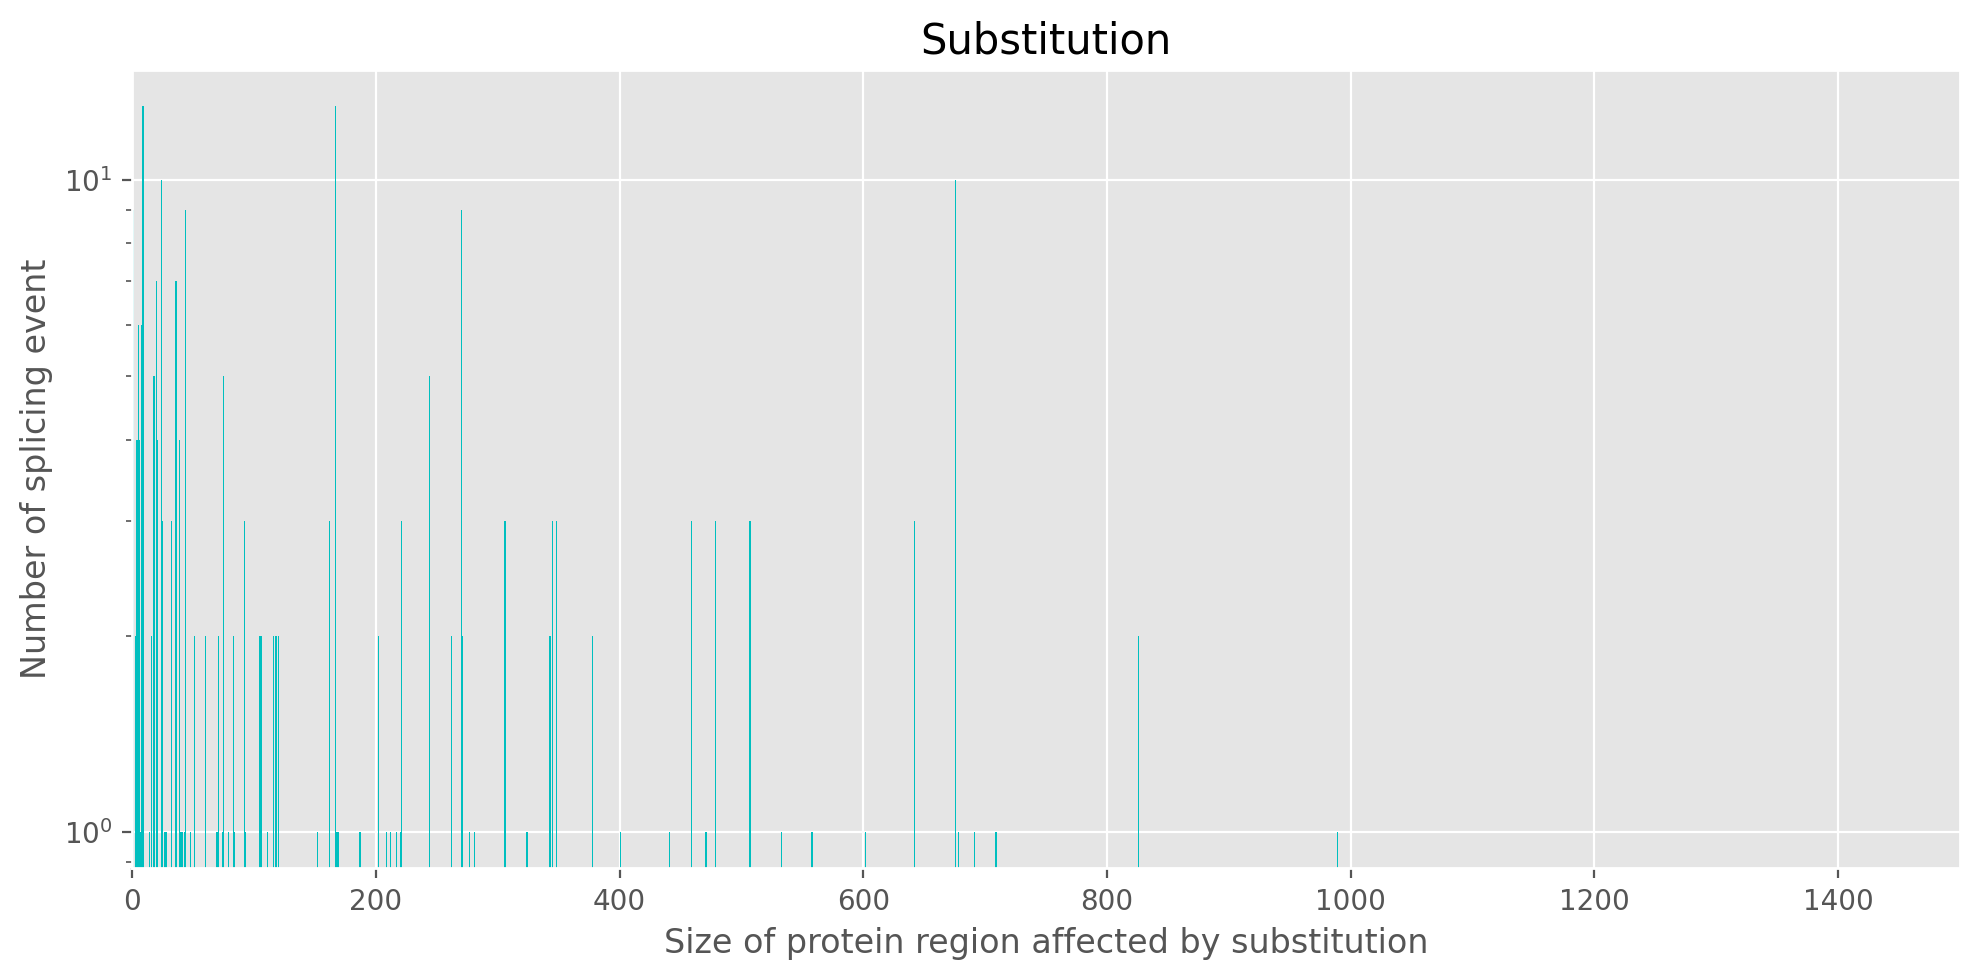

In [157]:

set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')


plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.title("Substitution", fontsize=15)
plt.xlabel('Size of protein region affected by substitution')
plt.ylabel('Number of splicing event')

plt.bar(x1, y1, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
#fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram_S.png',dpi=1200)

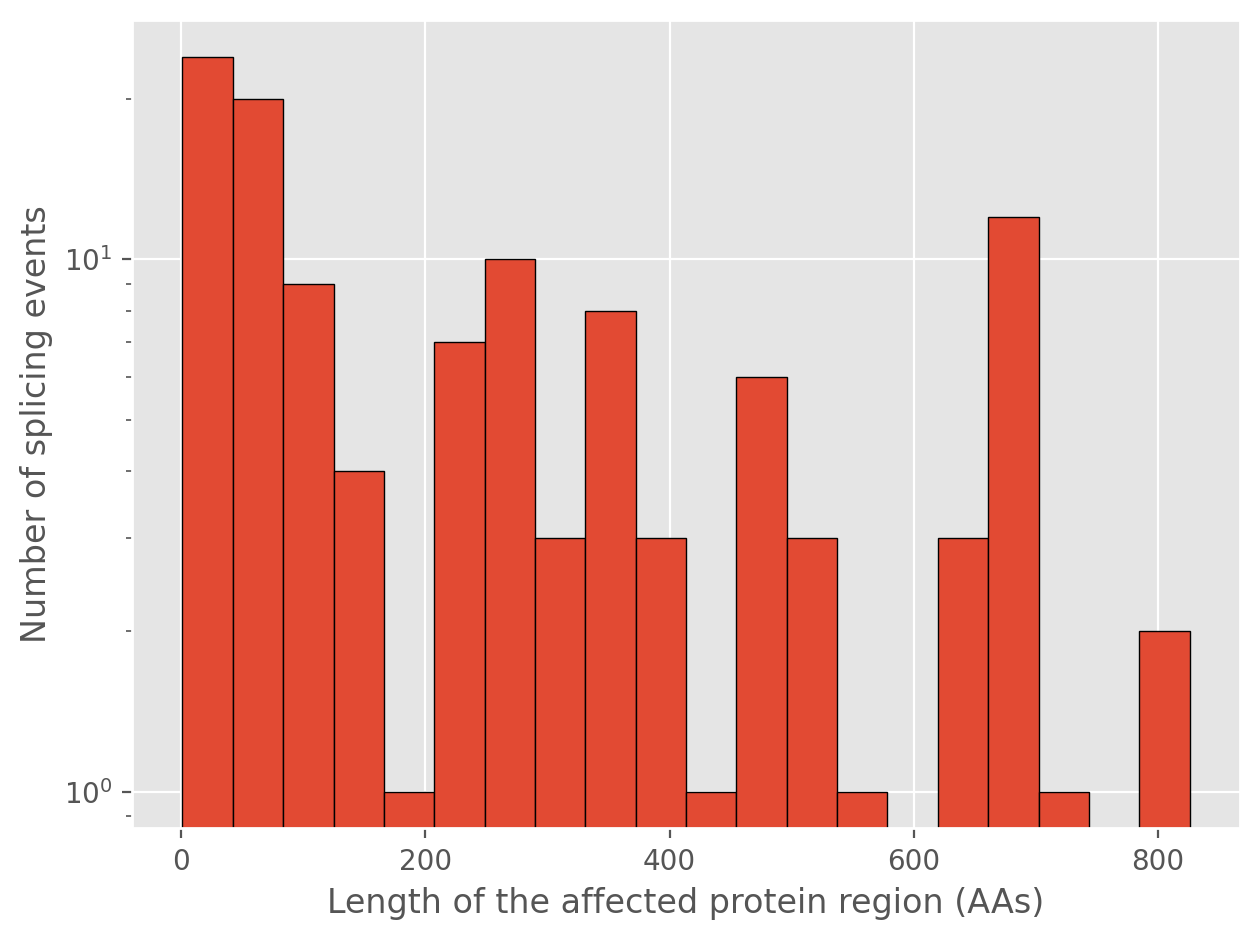

In [158]:
plt.hist(pb_stats_size_S, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 6: Number of isoforms vs count of splice events affecting protein region plot for ragged and clean I/D/S

In [164]:
wb = op.load_workbook(r'pblock_intermediate.xlsx')
sh = wb.active 

ref_s=[]
alt_s=[]

def getsize(c1_pb_anch_start, c1_pb__anch_stop, c1_pb_othr_start, c1_pb_othr_stop):

    size_ref = c1_pb_anch_stop-c1_pb_anch_start
    size_alt = c1_pb_othr_stop-c1_pb_othr_start
    ref_s.append(size_ref)
    alt_s.append(size_alt)
    return 0


for i in range(2, sh.max_row):
    c1_pb_cat, c2_pb_cat = sh.cell(row=i, column=4), sh.cell(row=i+1, column=4)
    c1_pb_anch_start, c2_pb_anch_start = sh.cell(row=i, column=5), sh.cell(row=i+1, column=5)
    c1_pb_anch_stop, c2_pb_anch_stop = sh.cell(row=i, column=6), sh.cell(row=i+1, column=6)
    c1_pb_othr_start, c2_pb_othr_start = sh.cell(row=i, column=7), sh.cell(row=i+1, column=7)
    c1_pb_othr_stop, c2_pb_othr_stop = sh.cell(row=i, column=8), sh.cell(row=i+1, column=8)
            
    if (c1_pb_cat.value!=c2_pb_cat.value) and (c1_pb_anch_start!=c2_pb_anch_start) and (c1_pb__anch_stop!=c2_pb_anch_stop) and (c1_pb_othr_start!=c2_pb_othr_start) and (c1_pb_othr_stop!=c2_pb_othr_stop):
        if c1_pb_cat == "SUBSTITUTION":
            print(c1_pb_cat.value)
            getsize(c1_pb_anch_start.value, c1_pb_anch_stop.value, c1_pb_othr_start.value, c1_pb_othr_stop.value)
        

/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


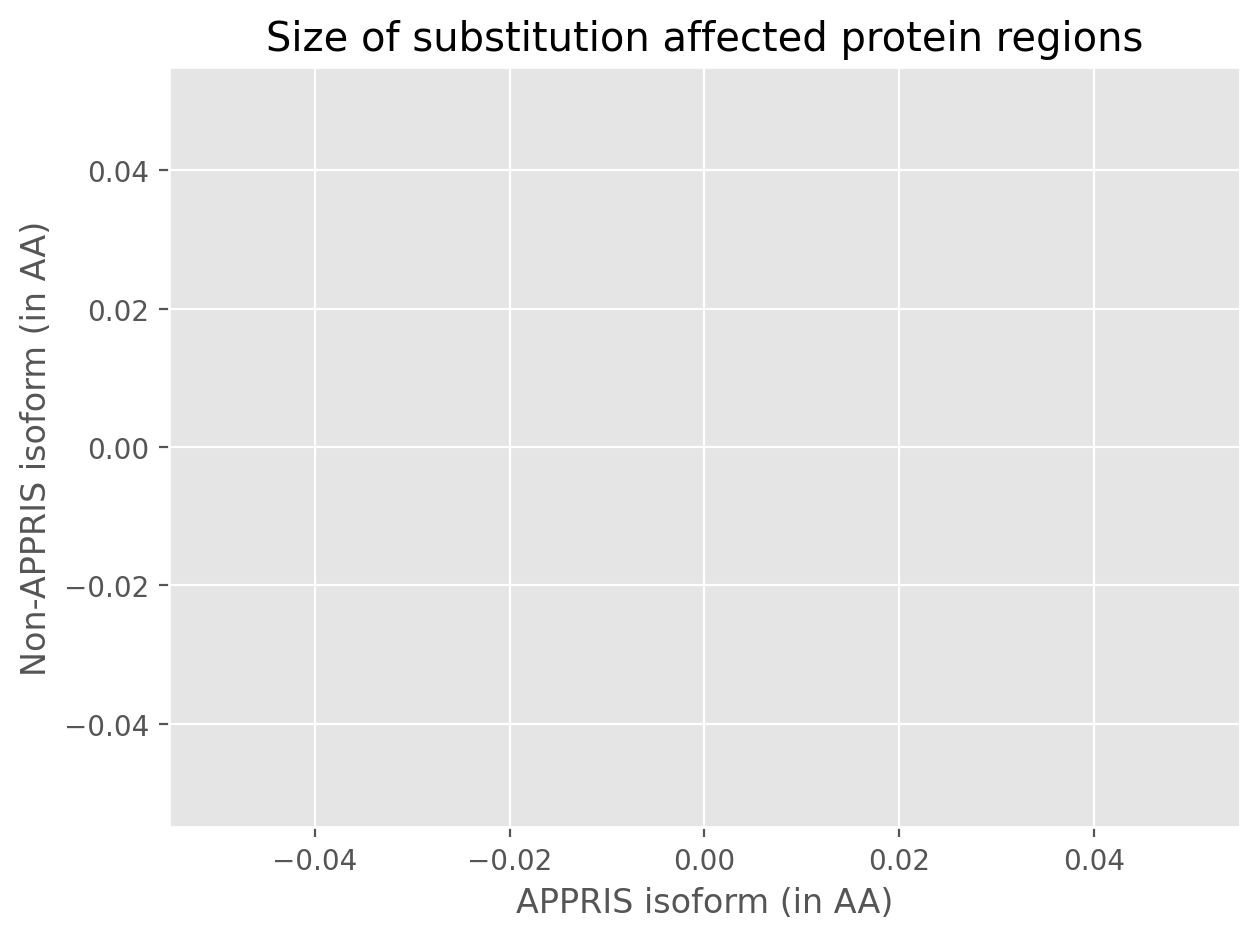

In [165]:
plt.style.use('ggplot')
plt.scatter(ref_s,alt_s)
plt.xlabel('APPRIS isoform (in AA)')
plt.ylabel('Non-APPRIS isoform (in AA)')
plt.title('Size of substitution affected protein regions')

plt.show()
#Saving figure
#fig.savefig('../../C_toy_plots/isoform_substitution_categories.png',dpi=1200)

In [122]:
# Modify intermediate table
df = pd.read_excel('intermediate.xlsx')
df.head()
wb_i = op.load_workbook(r'intermediate.xlsx')
sheet_i=wb_i.active

c_rid =False
c_re=False
r=1

for i in range(2, sheet_i.max_row):
    c1_iso, c2_iso = sheet_i.cell(row=i, column=3), sheet_i.cell(row=i+1, column=3)
    c1_pb, c2_pb = sheet_i.cell(row=i, column=4), sheet_i.cell(row=i+1, column=4)
    c1_cb, c2_cb = sheet_i.cell(row=i, column=5), sheet_i.cell(row=i+1, column=5)
    if c1_iso.value == c2_iso.value:
        if c1_pb.value == c2_pb.value:
            #print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
            if str(c1_cb.value).startswith("d") or str(c2_cb.value).startswith("d") or str(c1_cb.value).startswith("i") or str(c2_cb.value).startswith("i"):
                c_rid = True
            
            if str(c1_cb.value).startswith("e") or str(c2_cb.value).startswith("e"):
                c_re = True  
            r+=1

        else:
            if (c_rid == True and c_re == True):
                if str(c1_pb.value).startswith("S"):
                    #print(c1_pb.value, r)
                    for k in range(0, r):
                        sheet_i.cell(row=i-k, column=8).value = "ragged_S"
            c_rid =False
            c_re=False
            r=1

    else:
        if (c_rid == True and c_re == True):
            if str(c1_pb.value).startswith("S"):
                #print(c1_pb.value, r)
                for k in range(0, r):
                    sheet_i.cell(row=i-k, column=8).value = "ragged_S"



        c_rid =False
        c_re=False
        r=1
sheet_i.delete_cols(5)
wb_i.save('intermediate.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'intermediate.xlsx'